In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose, STL

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

In [2]:
x = pd.read_csv("C:/Users/user/Desktop/test_data_analyst.csv", index_col=0)
x['date']=pd.to_datetime(x["date"], format="%Y.%m.%d %H:%M:%S")

Нашим таргетом будет количество посетителей в день. Выделим его из начальных данных. Уберём первый и последний день, потому что в них наблюдения не за целые сутки.


In [3]:
x['day']=x['date'].apply(lambda v: datetime(v.year, v.month, v.day))
day_traffic=x.groupby(['day'])['inetnum'].count().to_frame()[1:92]
day_traffic.rename(columns={'inetnum': 'num'}, inplace=True)

Посмотрим на распределение таргета. Видим выброс 1 января, который повлияет на качество модели. От выброса нужно избавиться: заменим фактические значения 31.12-02.01 предсказанием модели на основании предыдущих данных.

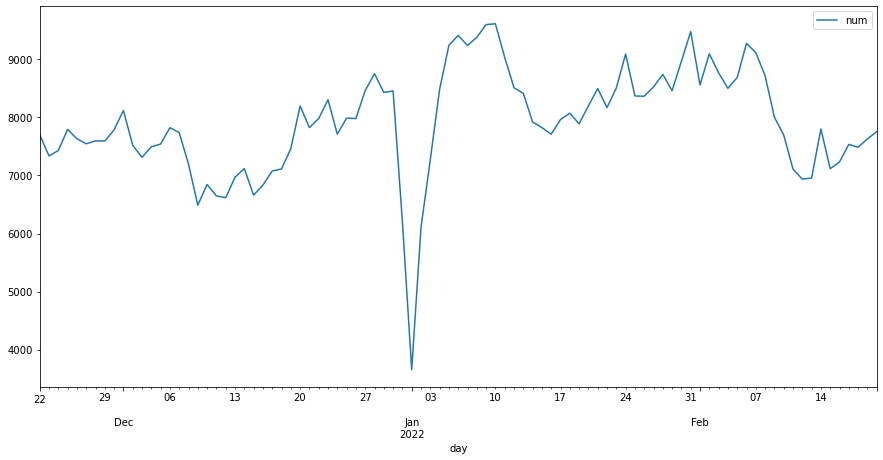

In [4]:
day_traffic.plot(title="", figsize=(15, 7));

Для предсказания настроим и используем модель SARIMA

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(day_traffic.num, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Выберем лучшие параметры и обучим модель:

In [6]:
best_model = sm.tsa.statespace.SARIMAX(day_traffic.num, order=(1, d, 3), 
                                        seasonal_order=(0, D, 0, 7)).fit(disp=-1)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Посмотрим на её предсказания вокруг 1-го января в сравнении с данными. Видим, что предсказание равномерно, поэтому используем его.

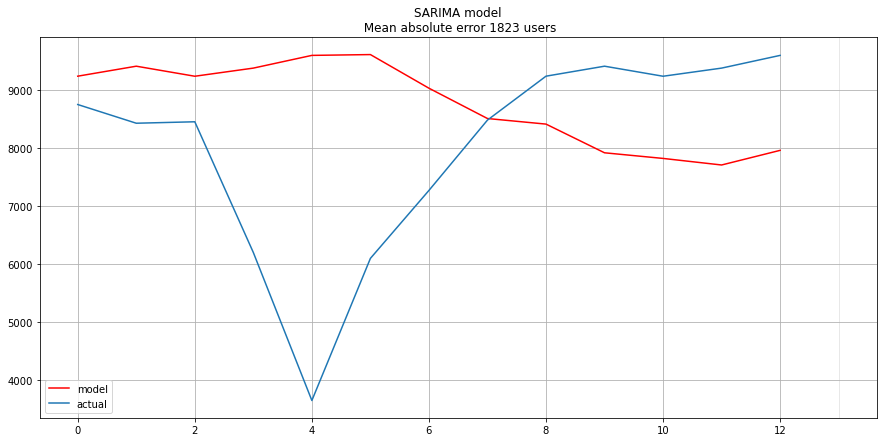

In [7]:
forecast = best_model.predict(start = day_traffic.shape[0], end = day_traffic.shape[0]+7)
forecast = day_traffic.num.append(forecast).values[-55:-42]
actual = day_traffic.num.values[-55:-42]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.plot(actual, label="actual")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(actual, forecast))))

plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [10]:
data=day_traffic.copy()
data['num'][-52:-49]=forecast[3:6]

Посмотрим на исправленный график:

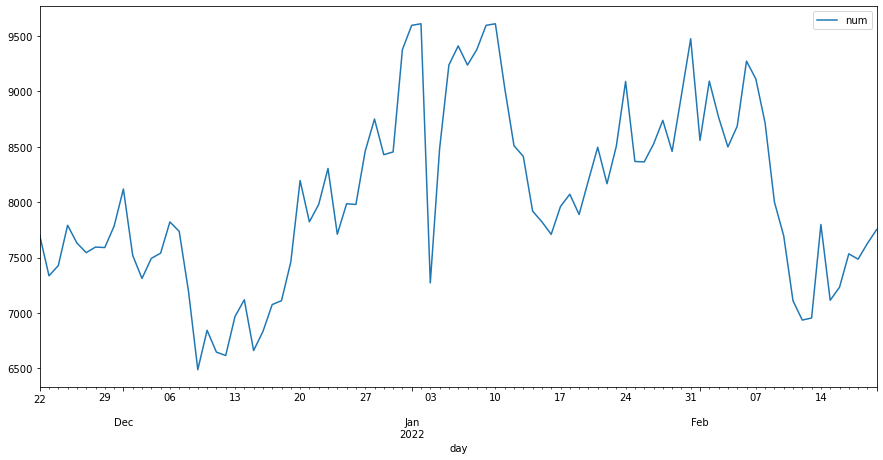

In [11]:
data.plot(title="", figsize=(15, 7));

Выделим признаки: день недели, выходные (Новый год не включён, потому что мы его сгладили), среднее число посетителей в каждый день недели, число посетителей за каждый из последних семи дней. Разобьём выборку на тренировочную и тестовую.

In [12]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data['weekday_average']=list(map(code_mean(data, "weekday", "num").get, data.weekday))


test_size=0.15
test_index = int(len(data)*(1-test_size))
lag_start=1
lag_end=7
for i in range(lag_start, lag_end):
    data["lag_{}".format(i)] = data.num.shift(i)
    
data.drop(["weekday"], axis=1, inplace=True)
dt=data.copy()
dt = dt.reset_index(drop=True)
dt=dt.dropna()

    # разбиваем весь датасет на тренировочную и тестовую выборку
X_train = dt.loc[:test_index].drop(["num"], axis=1)
y_train = dt.loc[:test_index]["num"]
X_test = dt.loc[test_index:].drop(["num"], axis=1)
y_test = dt.loc[test_index:]["num"]


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Обучим модель линейной регресси и сравним предсказание на тесте.
В качестве метрики возьмём среднюю разницу между предсказанием и фактом. Видим, что ошибка получилось небольшой: 343 человека. 

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


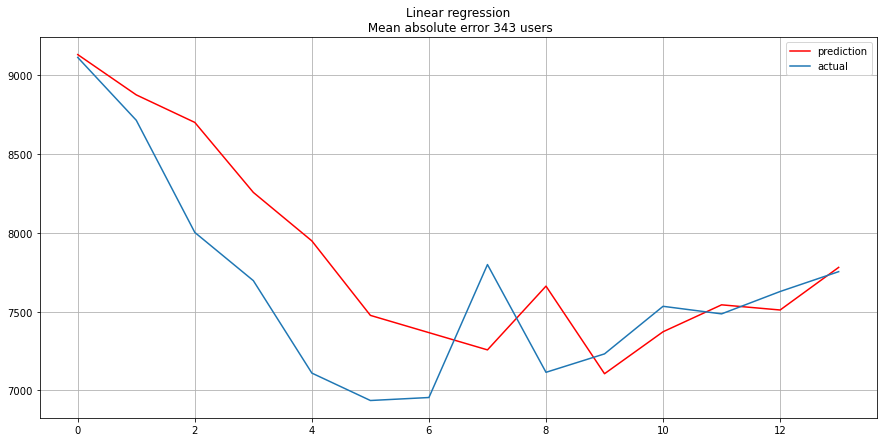

In [13]:
from sklearn.linear_model import LinearRegression

#X_train, X_test, y_train, y_test = prepareData(data.num, test_size=0.3, lag_start=1, lag_end=7)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Теперь сравним предсказание модели с начальными данными на всей выборке за исключением первой недели. Видим, что модель довольно точно предсказывает поведение ряда, поэтому можно найти выбросы, основываясь на предсказании модели. 

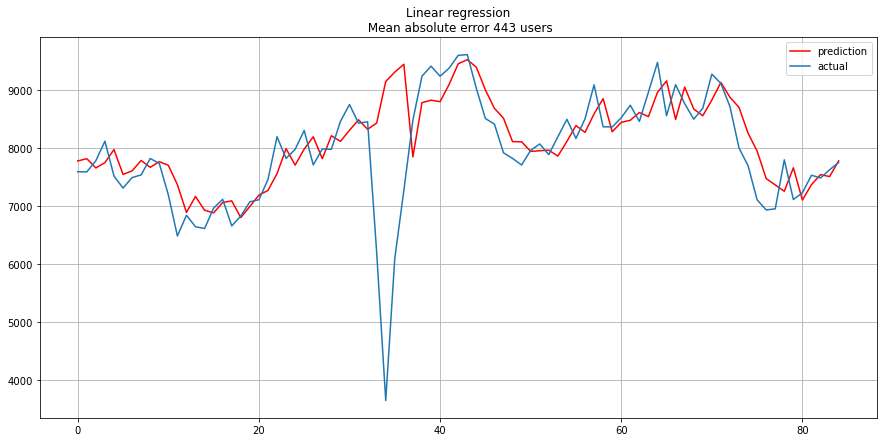

In [15]:
prediction1 = lr.predict(data.drop(['num'], axis=1)[-85:])
plt.figure(figsize=(15, 7))
plt.plot(prediction1, "r", label="prediction")
plt.plot(day_traffic["num"][-85:].values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction1, day_traffic["num"][-85:]))))
plt.grid(True);

В качестве метрики для обнаружения выбросов возьмём MAPE (отношение разницы между фактом и предсказанием к фактическому значению):

In [27]:
res=day_traffic.num[-85:].copy().to_frame()
res['prediction_lr']=prediction1
res['MAPE_lr']=abs(res.num-res.prediction_lr)/res.num
threshold_MAPE_lr=np.percentile(res.MAPE_lr, 90) 
res['anomaly_MAPE_lr']=res.MAPE_lr>threshold_MAPE_lr

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Посмотрим на распределение ошибки.

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

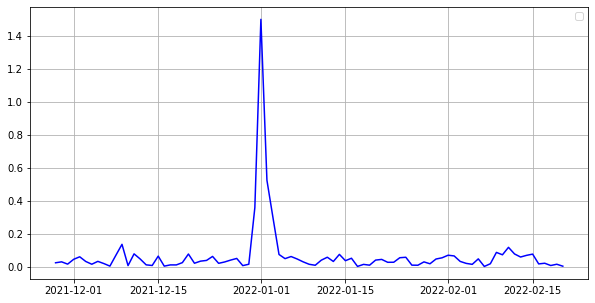

In [28]:
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(res.index, res.MAPE_lr, color='blue')
plt.legend(loc="best")
plt.grid(True)
plt.show

В качестве порога для определения аномалий возьмём 90 процентиль от метрики. Отметим все значения, превышающие пороговые значения, на графике. Видим, что кроме новогодних праздников есть аномальный спад в середине декабря и в середине февраля. 

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<function matplotlib.pyplot.show(close=None, block=None)>

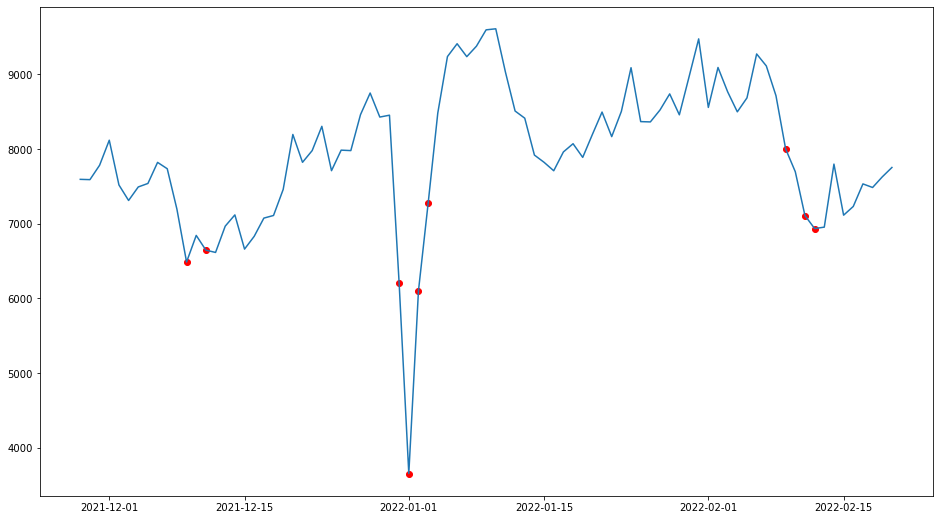

In [29]:
fig, ax =plt.subplots(figsize=(16,9))
a=res.loc[res['anomaly_MAPE_lr'], ['num']]
ax.plot(res.index, res.num)
ax.scatter(a.index, a.num, color='red')
plt.show

Теперь настроим и обучим ещё одну модель XGBoost.
Средняя ошибка предсказания немного выше, чем на простой линейной модели.

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

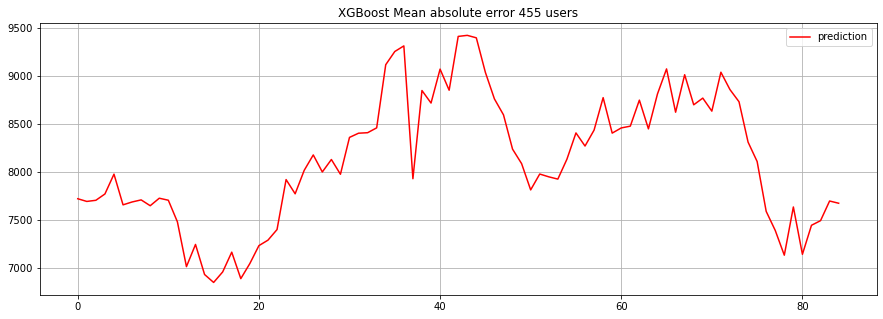

In [31]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
params = {
    'objective': 'reg:linear',
    'booster':'gblinear'
}
trees = 1000
scale=1.96
cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

traindata = xgb.DMatrix(data.drop(['num'], axis=1)[-85:], label=data.num[-85:])
prediction_train = bst.predict(traindata)
plt.figure(figsize=(15, 5))
plt.plot(prediction_train, "r", label="prediction")
plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(bst.predict(traindata), day_traffic.num[-85:]))))
plt.legend(loc="best")
plt.grid(True)



Посчитаем ошибку и посмотрим на её распределение. В целом, оно совпадает с ошибкой линейной модели.

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

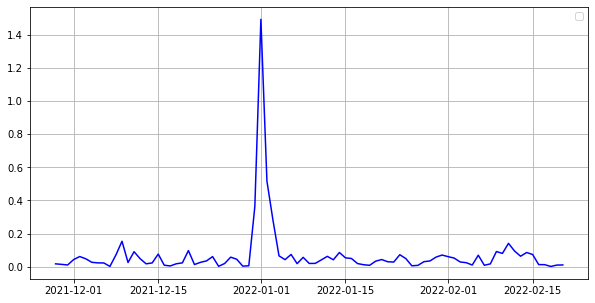

In [33]:
res['prediction_xgb']=prediction_train
res['MAPE_xgb']=abs(res.num-res.prediction_xgb)/res.num
threshold_MAPE=np.percentile(res.MAPE_xgb, 90) 
res['anomaly_MAPE_xgb']=res.MAPE_xgb>threshold_MAPE
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(res.index, res.MAPE_xgb, color='blue')
plt.legend(loc="best")
plt.grid(True)
plt.show

Посмотрим на аномалии. Модель выделяет немного другие точки, но улавливает новогодний выброс и спад середины декабря и февраля. 

<function matplotlib.pyplot.show(close=None, block=None)>

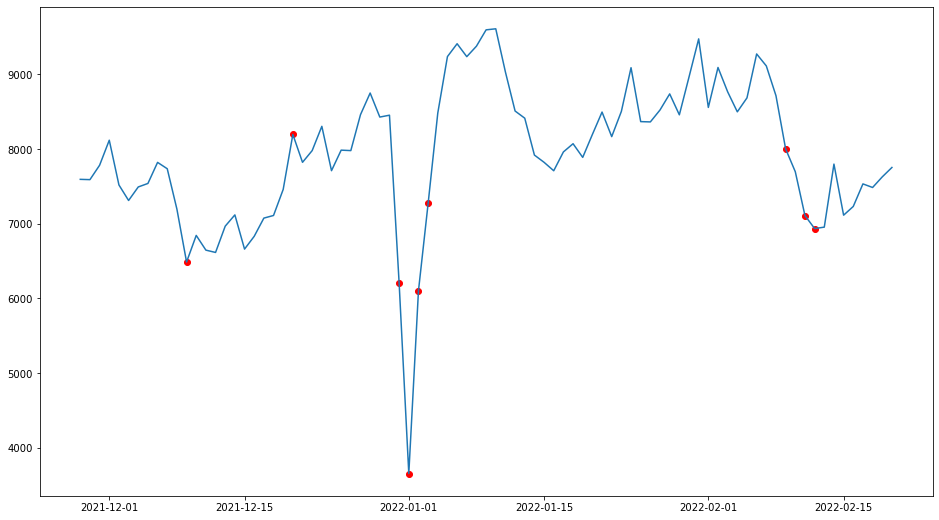

In [35]:
fig, ax =plt.subplots(figsize=(16,9))
a=res.loc[res['anomaly_MAPE_xgb'], ['num']]
ax.plot(res.index, res.num)
ax.scatter(a.index, a.num, color='red')
plt.show